# Wrangling Data From Bay Area Bike Share Published Data - Stations

### Import Packages

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import datetime

import seaborn as sns
sns.set_style('whitegrid')
sns.set_context("poster")

<p> Set some notebook variables, makes the notebook 95% width of the screen for easier viewing</p>

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

<p> Set some global font sizes for plots </p>

In [3]:
font = {'size'   : 50}
matplotlib.rc('font', **font)

LABEL_FONT_SIZE = 15
TITLE_FONT_SIZE = 25

## Key Dates from data source notes

In [4]:
FIRST_SERVICE_DATE = datetime.datetime.strptime('2013-08-29', '%Y-%m-%d')
LAST_SERVICE_DATE  = datetime.datetime.strptime('2016-08-31', '%Y-%m-%d')

## Import Data

In [5]:
print('Started Loading Station Data...')
file_path_slug = '../source_data/bayareabikeshare/*_station_data.csv'
file_list = glob(file_path_slug)

stations_df = pd.DataFrame()

counter = 1
chunks = []

for file in file_list:

    for chunk in pd.read_csv(file, chunksize=10000, iterator=True):
        chunk.columns = ['station_id', 'name', 'lat', 'long', 'dock_count', 'landmark', 'first_service_date']
        chunks.append(chunk)
        
    print('\tFinished file! (%d of %d)' % (counter, len(file_list)))
    counter += 1
    
stations_df = pd.concat(chunks)
print('Data Loaded Successfully!')

Started Loading Station Data...
	Finished file! (1 of 4)
	Finished file! (2 of 4)
	Finished file! (3 of 4)
	Finished file! (4 of 4)
Data Loaded Successfully!


## Cleaning Support Functions
<p>General Cleaning functions</p>

In [6]:
def clean_data_types(df):
    ''' given a station dataframe, clean pu the datatype for each column '''
    
    # these data columns are included in the imported data set
    df['station_id']         = df['station_id'].astype('int')
    df['name']               = df['name'].astype('str')
    df['lat']                = df['lat'].astype('float')
    df['long']               = df['long'].astype('float')
    df['landmark']           = df['landmark'].astype('category')
    df['dock_count']         = df['dock_count'].astype('int')
    df['first_service_date'] = pd.to_datetime(df['first_service_date'], format='%m/%d/%Y', errors='coerce')
    
    
    # these data columns are added through the cleaning process, onyl clean them if they exist
    try:
        df['last_service_date']  = pd.to_datetime(df['last_service_date'], format='%m/%d/%Y', errors='coerce')
        df['zip_code']           = df['zip_code'].astype('str')
        df['days_in_service']    = df['days_in_service'].astype('int')
    except:
        pass
    
    
    return df

def landmark_to_zip(row):
    ''' Return zipcode for given landmark'''
    if row['landmark'] == 'San Francisco':
       return 94107
    if row['landmark'] == 'Redwood City':
        return 94063
    if row['landmark'] == 'Palo Alto':
        return 94301
    if row['landmark'] == 'Mountain View':
        return 94041
    if row['landmark'] == 'San Jose':
        return 95113
    return 99999


def correct_first_service_date(row):
    ''' adjust first service dates which are prior to the program start date'''
    if row.first_service_date < FIRST_SERVICE_DATE:
        result = FIRST_SERVICE_DATE
    else:
        result = row.first_service_date
    return result


def days_in_service(row):
    ''' returns an integer of the number of days the statin was in service'''
    days_in_service = row.last_service_date - row.first_service_date
    
    try:
        result = int(days_in_service.days)
    except:
        result = 999999
    
    return result

## Cleaning Data

In [7]:
print('Station Data Cleanup Started...')
# drop na values and drop duplicates
stations_df.dropna(how='all', inplace=True)
stations_df.drop_duplicates(inplace=True)


# cleanup data types
stations_df = clean_data_types(stations_df)

# sort by 'station_id' and rest index
stations_df.sort_values('station_id', inplace=True)
stations_df.reset_index(drop=True, inplace=True)
print('\tStation Data Cleanup Complete!')

Station Data Cleanup Started...
	Station Data Cleanup Complete!


## Add some Columns
<p> Appending columns of data from other data sets, or from computations on given data.</p>

In [8]:
# add 'last_service_date' column to coenside with last data from data
stations_df['last_service_date'] = LAST_SERVICE_DATE

# add 'zipcode' column to station, this is handy for cross comparison to other datasets
stations_df['zip_code'] = stations_df.apply(lambda row: landmark_to_zip (row), axis=1)

## Special Cleaning Notes
<p>This data set is not so large that some cleaning is more easily done manually from notes included from Bay Area Bike Share.</p>

In [9]:
def clean_from_notes(df):
    ''' Manual Fixes from included notes in publisehd dataset'''
    
    index_drop_list = []
    
    # FROM NOTES - correct installation dates prior to 8/29/13, to 8/29/13
        # Cleaning Step : adjust all dates prior to service start dates to FIRST_SERVICE_DATE
    df['first_service_date'] = df.apply(lambda row: correct_first_service_date (row), axis=1)

    # FROM NOTES - Station 23: From 9/1/14 – 10/22/14: This station was located at (37.488501, -122.231061). 
        # Cleaning Step : this move is across the block, throw out new location record
    index_drop_list.append(17)
    df.loc[17, 'station_id'] = 'JUNK'

    # FROM NOTES - Station 25: From 9/1/14 – 10/22/14: This station was located at (37.486725, -122.225551). It was previously named “Broadway at Main.”
        # Cleaning Step : station is renamed and moved over a mile, set end and start dates for row
    df.loc[19,'last_service_date']  = datetime.datetime.strptime('2014-09-01', '%Y-%m-%d')
    df.loc[20,'first_service_date'] = datetime.datetime.strptime('2014-09-01', '%Y-%m-%d')

    # FROM NOTES - Station 49: From 9/1/14 - 2/5/15: This station was located at (37.789625, -122.390264). 
        # Cleaning Step : station was moved around the block, throw out new location record
    index_drop_list.append(44)
    df.loc[44, 'station_id'] = 'JUNK'
    
    
    # FROM NOTES - Station 69: From 9/1/14 – 3/11/15: This station was located at (37.776377,-122.39607). 
        # Cleaning Step : station was moved around the block, throw out new location record
    index_drop_list.append(63)
    df.loc[63, 'station_id'] = 'JUNK'
        

    # FROM NOTES - Station 72: Moved twice. From 9/1/14 – 2/12/15, this station was located at (37.780356, -122.412919). 
    #                                       From 2/13/15 to 6/3/15, the station was located at (37.780353, -122.41226). 
        # Cleaning Step : the statio was only relocated once on 2/13/15, not twice.  move was around the corner, toss out latest record
    index_drop_list.append(67)
    df.loc[67, 'station_id'] = 'JUNK'
        

    # FROM NOTES - Station 80: On 9/1/14, this station changed names from "San Jose Government Center" to "Santa Clara County Civic Center." It did not move.
        # Cleaning Step : name change, second name is better, throw out original name
    index_drop_list.append(74)
    df.loc[74, 'station_id'] = 'JUNK'
        

    # FROM NOTES - Station 21: On 9/16/15, this station was renamed from "Franklin at Maple" to "Sequoia Hospital" and moved to (37.479303,-122.253755)
        # Cleaning Step : this is a significant move, create a new row, and adjust start and end dates
    df.loc[14,'last_service_date']  = datetime.datetime.strptime('2015-09-16', '%Y-%m-%d')
    station_21_copy = df.loc[14,:].copy()
    station_21_copy.lat = 37.479303
    station_21_copy.long = -122.253755
    station_21_copy.first_service_date = datetime.datetime.strptime('2015-09-16', '%Y-%m-%d')
    station_21_copy.last_service_date = LAST_SERVICE_DATE
    df.loc[100] = station_21_copy
    df.loc[100, 'name'] = 'Sequoia Hospital'


    # FROM NOTES - Station 26: On 9/16/15, this station was renamed from "Redwood City Medical Center" to "Kaiser Hospital" and moved to (37.489704,-122.224728)
        # Cleaning Step :  station was moved around the block, nothing to do here
    
    
    # FROM NOTES - Station 30: On 9/28/15, this station was renamed from "Evelyn Park and Ride" to "Middlefield Light Rail Station" and moved to (37.395337,-122.052476)
        # Cleaning Step : this is a substantial move, update start and end dates
    df.loc[25,'last_service_date']  = datetime.datetime.strptime('2015-09-28', '%Y-%m-%d')
    df.loc[26,'first_service_date'] = datetime.datetime.strptime('2015-09-28', '%Y-%m-%d')


    # FROM NOTES - Station 33: On 9/16/15, this station was renamed from "Rengstorff Avenue / California Street" to "Charleston Park/ North Bayshore Area" and moved to (37.420909,-122.080623)
        # Cleaning Step : this is a substantial move, update start and end dates
    df.loc[29,'last_service_date']  = datetime.datetime.strptime('2015-09-16', '%Y-%m-%d')
    df.loc[30,'first_service_date'] = datetime.datetime.strptime('2015-09-16', '%Y-%m-%d') 


    # FROM NOTES - Station 73: Moved twice. From 3/14/16 – 5/19/16, this station was located at (37.797746, -122.407073). From 5/19/16 to 8/31/16, the station was located at (37.7979, -122.405942). The station name stayed the same for all moves. 
        # Cleaning Step : the move is around the block, but mor stations were added
    df.loc[68,'last_service_date']  = datetime.datetime.strptime('2015-05-19', '%Y-%m-%d')
    df.loc[69,'first_service_date'] = datetime.datetime.strptime('2015-05-19', '%Y-%m-%d')


    # FROM NOTES - Station 83: On 9/16/15, this station was renamed from "Mezes Park" to "Mezes" and moved to (37.491405,-122.233051)
        # Cleaning Step : moved around corner, nothing to clean


    # FROM NOTES - Note 2: On 6/30/16, Service in Redwood City was discontinued due to low usage. This included 7 stations: 21, 22, 23, 24, 25, and 26.
        # Cleaning Step : set last_service_date on these stations
    df.loc[15,'last_service_date']  = datetime.datetime.strptime('2016-06-30', '%Y-%m-%d')
    df.loc[16,'last_service_date']  = datetime.datetime.strptime('2016-06-30', '%Y-%m-%d')
    df.loc[17,'last_service_date']  = datetime.datetime.strptime('2016-06-30', '%Y-%m-%d')
    df.loc[18,'last_service_date']  = datetime.datetime.strptime('2016-06-30', '%Y-%m-%d')
    df.loc[19,'last_service_date']  = datetime.datetime.strptime('2016-06-30', '%Y-%m-%d')
    df.loc[20,'last_service_date']  = datetime.datetime.strptime('2016-06-30', '%Y-%m-%d')
    df.loc[21,'last_service_date']  = datetime.datetime.strptime('2016-06-30', '%Y-%m-%d')
    df.loc[77,'last_service_date']  = datetime.datetime.strptime('2016-06-30', '%Y-%m-%d')
    df.loc[100,'last_service_date']  = datetime.datetime.strptime('2016-06-30', '%Y-%m-%d')  # station 21 update, special index
    

    # FROM NOTES - Four of these stations have since been moved to either San Francisco or San Jose. (Stations 23, 24, 25 and 26 have become stations 88, 89, 90 and 91 respectively). Although these stations were promptly re-named, there was a delay in assigning them new station IDs. Full details:
        # Cleaning Step 


    # FROM NOTES - On 7/5/16, Station 23, "San Mateo County Center," was renamed to be "5th S. at E. San Salvador St.” On 8/24/16, the station was reassigned to Station 88.
        # Cleaning Step :  79
    df.loc[16, 'last_service_date']  = datetime.datetime.strptime('2016-07-05', '%Y-%m-%d')
    df.loc[79,'first_service_date']  = datetime.datetime.strptime('2016-07-05', '%Y-%m-%d')


    # FROM NOTES - On 7/5/16, Station 24, "Redwood City Public Library," was renamed to be "S. Market St at Park Ave.” On 8/24/16, the station was reassigned to Station 89.
        # Cleaning Step :  80
    df.loc[18, 'last_service_date']  = datetime.datetime.strptime('2016-07-05', '%Y-%m-%d')
    df.loc[80,'first_service_date']  = datetime.datetime.strptime('2016-07-05', '%Y-%m-%d')


    # FROM NOTES - On 8/4/16, Station 25, "Stanford in Redwood City," was renamed to be "Cyril Magnin St at Ellis St.” On 8/24/16, the station was reassigned to Station 91.
        # Cleaning Step :  82
    df.loc[20, 'last_service_date']  = datetime.datetime.strptime('2016-08-04', '%Y-%m-%d')
    df.loc[82,'first_service_date']  = datetime.datetime.strptime('2016-08-04', '%Y-%m-%d')


    # FROM NOTES - On 8/4/16, Station 26, "Kaiser Hospital," was renamed to be "5th St at Folsom St.” On 8/24/16, the station was reassigned to Station 90.
        # Cleaning Step :  81
    df.loc[21, 'last_service_date']  = datetime.datetime.strptime('2016-08-04', '%Y-%m-%d')
    df.loc[81,'first_service_date']  = datetime.datetime.strptime('2016-08-04', '%Y-%m-%d')
    

    # drop all rows in drop list and clean/reset index
    df.drop(index_drop_list, inplace=True)
    df.sort_values(['station_id', 'first_service_date'], inplace=True)
    df.reset_index(inplace=True, drop=True)
    
    
    return df

In [10]:
stations_df = clean_from_notes(stations_df)

In [11]:
stations_df.tail()

,station_id,name,lat,long,dock_count,landmark,first_service_date,last_service_date,zip_code
74,84,Ryland Park,37.342725,-121.895617,15,San Jose,2014-04-09,2016-08-31,95113
75,88,5th S. at E. San Salvador St,37.331957,-121.881630,19,San Jose,2016-07-05,2016-08-31,95113
76,89,S. Market st at Park Ave,37.332398,-121.890429,19,San Jose,2016-07-05,2016-08-31,95113
77,90,5th St at Folsom St,37.780148,-122.403158,31,San Francisco,2016-08-04,2016-08-31,94107
78,91,Cyril Magnin St at Ellis St,37.785908,-122.408891,35,San Francisco,2016-08-04,2016-08-31,94107


## Add some more Columns
<p> Appending a few final columns of data from computations on given data.</p>

In [12]:
# days in service is useful for popularity comparison as some stations were opened and closed on different dates
stations_df['days_in_service'] = stations_df.apply(lambda row: days_in_service (row),axis=1)

# final data type cleaning pass
stations_df = clean_data_types(stations_df)

# Write Data to File

In [13]:
stations_df.to_csv('../clean_data/bayareabikeshare/station_data_cleaned.csv', encoding='utf-8')

***
# Preview EDA of Stations Data

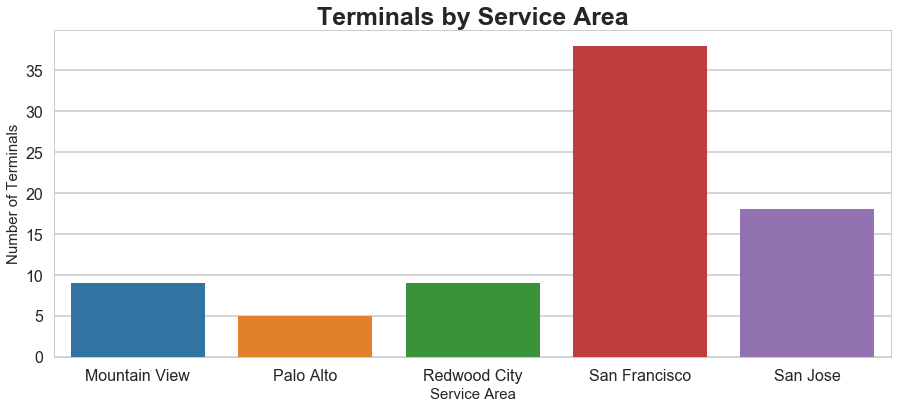

In [14]:
docks_by_service_area = stations_df.groupby('landmark')['dock_count'].count().to_frame()
plt.subplots(figsize=(15,6))
ax = sns.barplot(x=docks_by_service_area.index, y='dock_count', data=docks_by_service_area)
ax.set_title('Terminals by Service Area', size=TITLE_FONT_SIZE, weight='bold')
ax.set_xlabel('Service Area', size=LABEL_FONT_SIZE)
ax.set_xticklabels(sorted(pd.unique(stations_df.landmark)), rotation=0)
ax.set_ylabel('Number of Terminals', size=LABEL_FONT_SIZE)
plt.savefig('../charts/01_Terminals_By_Service_Area.png')

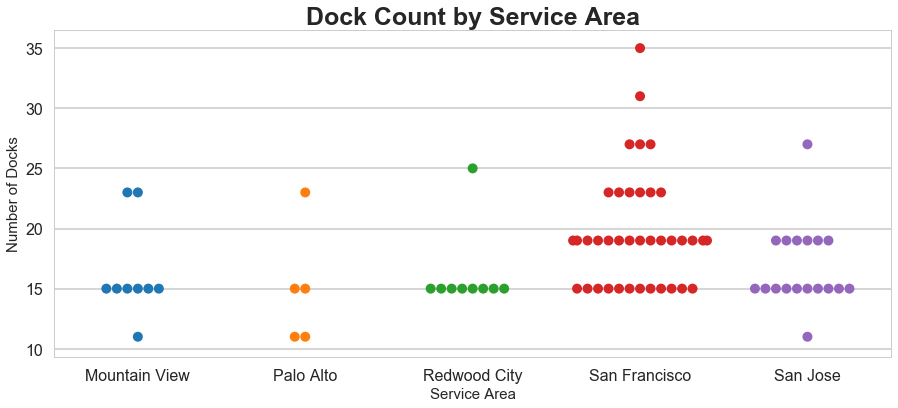

In [15]:
plt.subplots(figsize=(15,6))
ax = sns.swarmplot(x='landmark', y='dock_count', data=stations_df, s=10)
ax.set_title('Dock Count by Service Area', size=TITLE_FONT_SIZE, weight='bold')
ax.set_xlabel('Service Area', size=LABEL_FONT_SIZE)
ax.set_ylabel('Number of Docks', size=LABEL_FONT_SIZE)
plt.savefig('../charts/01_Dock_Count_By_Service_Area.png')

# Quick Reference to 'Special Stations'
<p>Some stations were relocated, closed, or expanded during the program's recorded dataset being used in this analysis, this is a quick view to these notable stations</p>

In [16]:
# Stations that were relocated or expanded, thus there are duplicate 'station_id' values
special_stations = stations_df[stations_df.duplicated(subset=['station_id'], keep=False)]
special_stations.head(20)

,station_id,name,lat,long,dock_count,landmark,first_service_date,last_service_date,zip_code,days_in_service
14,21,Franklin at Maple,37.481758,-122.226904,15,Redwood City,2013-08-29,2015-09-16,94063,748
15,21,Sequoia Hospital,37.479303,-122.253755,15,Redwood City,2015-09-16,2016-06-30,94063,288
19,25,Stanford in Redwood City,37.485370,-122.203288,15,Redwood City,2013-08-29,2016-06-30,94063,1036
20,25,Broadway at Main,37.486725,-122.225551,15,Redwood City,2014-09-01,2016-08-04,94063,703
25,30,Evelyn Park and Ride,37.390277,-122.066553,15,Mountain View,2013-08-29,2015-09-28,94041,760
26,30,Middlefield Light Rail Station,37.395337,-122.052476,15,Mountain View,2015-09-28,2016-08-31,94041,338
29,33,Rengstorff Avenue / California Street,37.400241,-122.099076,15,Mountain View,2013-08-29,2015-09-16,94041,748
30,33,Charleston Park/ North Bayshore Area,37.420909,-122.080623,15,Mountain View,2015-09-16,2016-08-31,94041,350
65,73,Grant Avenue at Columbus Avenue,37.798522,-122.407245,15,San Francisco,2013-08-29,2015-05-19,94107,628
66,73,Grant Avenue at Columbus Avenue,37.797900,-122.405942,19,San Francisco,2015-05-19,2016-08-31,94107,470


In [17]:
# Service was discontinued due to low ridership in Redwood City on September 1, 2016
redwood_city = stations_df[stations_df.landmark == 'Redwood City']
redwood_city.head(20)

,station_id,name,lat,long,dock_count,landmark,first_service_date,last_service_date,zip_code,days_in_service
14,21,Franklin at Maple,37.481758,-122.226904,15,Redwood City,2013-08-29,2015-09-16,94063,748
15,21,Sequoia Hospital,37.479303,-122.253755,15,Redwood City,2015-09-16,2016-06-30,94063,288
16,22,Redwood City Caltrain Station,37.486078,-122.232089,25,Redwood City,2013-08-29,2016-06-30,94063,1036
17,23,San Mateo County Center,37.488501,-122.231061,15,Redwood City,2013-08-29,2016-07-05,94063,1041
18,24,Redwood City Public Library,37.484219,-122.227424,15,Redwood City,2013-08-29,2016-07-05,94063,1041
19,25,Stanford in Redwood City,37.485370,-122.203288,15,Redwood City,2013-08-29,2016-06-30,94063,1036
20,25,Broadway at Main,37.486725,-122.225551,15,Redwood City,2014-09-01,2016-08-04,94063,703
21,26,Redwood City Medical Center,37.487682,-122.223492,15,Redwood City,2013-08-29,2016-08-04,94063,1071
73,83,Mezes Park,37.491269,-122.236234,15,Redwood City,2014-02-20,2016-06-30,94063,861
